<a href="https://colab.research.google.com/github/Gus-1003/ISD-invention/blob/main/Pesquisa/4_Teste_Massivo_Modularizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas

In [ ]:
import os

import glob

import cv2

import numpy as np

import math

import pandas as pd

import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from google.colab import drive

drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


# Funções:

## Calcular_Distancia

In [ ]:
def calcular_distancia(x1, y1, x2, y2):
  # Calcula a diferença entre as coordenadas x e y
  diff_x = x2 - x1
  diff_y = y2 - y1

  # Calcula o quadrado das diferenças
  diff_x_squared = diff_x ** 2
  diff_y_squared = diff_y ** 2

  # Calcula a soma dos quadrados das diferenças
  sum_diff_squared = diff_x_squared + diff_y_squared

  # Calcula a raiz quadrada da soma dos quadrados das diferenças
  distancia = math.sqrt(sum_diff_squared)

  return distancia

## create_dataset_image:

In [ ]:
def create_dataset_image(dataset):
  # Cria uma lista vazia para armazenar os objetos
  objects = []

  # Percorre o dicionário
  for attr, obj_list in dataset.items():
    # Percorre a lista de objetos para o atributo atual
    for obj in obj_list:
      # Verifica se obj é um dicionário
      if isinstance(obj, dict):
        # Adiciona o objeto combinando com o dicionário {'attribute': attr}
        objects.append({**{'attribute': attr}, **obj})

  # Cria o DataFrame com base na lista de objetos
  df = pd.DataFrame(objects)

  # Retorna o DataFrame se for necessário usá-lo posteriormente
  return df

## calculate_contour_properties:

In [ ]:
def calculate_contour_properties(cnt):
  # Momentos do objeto
  M = cv2.moments(cnt)

  # Calcula a área do contorno
  area = cv2.contourArea(cnt)

  # Calcula o perímetro do contorno
  perimeter = cv2.arcLength(cnt, True)

  # Proporção de aspecto do objeto
  x,y,w,h = cv2.boundingRect(cnt)
  width = w
  height = h

  if min(w, h) == 0:
    aspect_ratio = 0
  else:
    aspect_ratio = max(float(w), h) / min(float(w), h)

  # Ângulo e raio mínimo envolvente em torno do objeto
  rect = cv2.minAreaRect(cnt)
  circle = cv2.minEnclosingCircle(cnt)

  box = cv2.boxPoints(rect)
  box = np.int0(box)

  # Extensão do objeto (razão entre a área do objeto e a área do retângulo envolvente mínimo)
  rect_area = w*h

  # Forma de achar o contorno 1
  center_x = int(M["m10"] / M["m00"])
  center_y = int(M["m01"] / M["m00"])

  # Forma de achar o contorno 2 - Circulo
  (x_circle, y_circle), radius = cv2.minEnclosingCircle(cnt)
  center_circle = (int(x_circle), int(y_circle))
  cx_circle = int(x_circle)
  cy_circle = int(y_circle)

  # Forma de achar o contorno 2 - Quadrado
  cx_quad = int(x)
  cy_quad = int(y)

  # Calcula a circularidade do contorno
  if perimeter > 0:
      circularity = 4 * np.pi * area / (perimeter ** 2)
  else:
      circularity = 0
      
  return area, circularity, radius, x, y, w, h, aspect_ratio, box, center_circle, cx_circle, cy_circle, cx_quad, cy_quad, center_x, center_y

## process_contours:

In [ ]:
def process_contours(nome_frame, img_contours, contours, imagem_original):

  objetos = 0
  dicionario = {}  # Dicionário para armazenar os dados dos objetos identificados

  for cnt in contours:
    # Aproxima o contorno por uma sequência de segmentos de linha
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

    # Calcula as propriedades do contorno
    area, circularity, radius, x, y, w, h, aspect_ratio, box, center, cx_circle, cy_circle, cx_quad, cy_quad, center_x, center_y = calculate_contour_properties(cnt)

    # Para um padrão Circular:
    if circularity > 0.30 and area > 2000 and radius < 100 and radius > 20:

      # Define o raio máximo desejado
      max_radius = 100

      # Limita o raio ao valor máximo
      radius = min(radius, max_radius)

      # Converte o raio para inteiro
      radius = int(radius)

      # Calcula as Distancias entre os pontos centrais
      distance_blue_green = calcular_distancia(cx_circle, cy_circle, center_x, center_y)

      # Desenha um contorno Circular
      cv2.circle(img_contours, center, radius, (0, 255, 0), 2)
      
      # Desenho do ponto central
      cv2.circle(img_contours, (cx_circle, cy_circle), 3, (0, 255, 0), -1) # Verde - minEnclosingCircle
      cv2.circle(img_contours, (center_x, center_y), 3, (255, 0, 0), -1) # Azul - Momentun

      # Contagem total de Objetos Identificados
      objetos = objetos + 1

      # Captura dos dados:
      dicionario[f"{nome_frame}_{objetos}"] = []
      # Adicione os dados desejados ao dicionário dataset
      dicionario[f"{nome_frame}_{objetos}"].append({
        "Form": "circle",
        "area": area,
        "circularity": circularity,
        "radius": radius,
        "x": x,
        "y": y,
        "w": w,
        "h": h,
        "cx_circle": cx_circle,
        "cy_circle": cy_circle,
        "cx_momentun": center_x,
        "cy_momentun": center_y,
        "distance_of_points" : distance_blue_green,
      })


    else:
      if aspect_ratio < 2 and area > 2000 and area < 4000:
        # Calcula as Distancias entre os pontos centrais
        distance_blue_green = calcular_distancia(cx_circle, cy_circle, center_x, center_y)

        # Desenha um contorno quadratico
        cv2.drawContours(img_contours, [box], 0, (0, 255, 0), 2)

        # Desenho do ponto central
        cv2.circle(img_contours, (cx_circle, cy_circle), 3, (0, 255, 0), -1) # verde - minEnclosingCircle
        cv2.circle(img_contours, (center_x, center_y), 3, (255, 0, 0), -1) # Azul - Momentun

        # Contagem total de Objetos Identificados
        objetos = objetos + 1
        dicionario[f"{nome_frame}_{objetos}"] = []
        dicionario[f"{nome_frame}_{objetos}"].append({
          "Form": "Fora do padrão",
          "area": area,
          "circularity": circularity,
          "radius": radius,
          "x": x,
          "y": y,
          "w": w,
          "h": h,
          "cx_circle": cx_circle,
          "cy_circle": cy_circle,
          "cx_momentun": center_x,
          "cy_momentun": center_y,
          "distance_of_points" : distance_blue_green,
        })

  return imagem_original, objetos, dicionario

## find_contours:

In [ ]:
def find_contours(image):
  # Encontra os contornos na imagem
  contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return contours

## dilate_image:

In [ ]:
def dilate_image(image):
  # Define o kernel para a dilatação
  kernel = np.ones((5, 5), np.uint8)

  # Dilata a imagem
  image = cv2.dilate(image, kernel, iterations=2)
  return image

## apply_threshold:

In [ ]:
def apply_threshold(image):
  # Aplica um filtro de Sobel em x e y
  sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

  # Calcula a magnitude do gradiente
  gradient_magnitude = cv2.magnitude(sobelx, sobely)

  # Normaliza a magnitude do gradiente
  gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  # Aplica uma limiarização utilizando o método de Otsu
  _, gradient_threshold = cv2.threshold(gradient_magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  
  return gradient_threshold

## apply_filters:

In [ ]:
def apply_filters(image):
  # Converte a imagem para float32
  image32f = np.float32(image)
  
  # Aplica um filtro de média
  mu = cv2.blur(image32f, (3, 3))

  # Calcula a variância da imagem filtrada
  mu2 = cv2.blur(image32f * image32f, (3, 3))
  sigma = cv2.sqrt(mu2 - mu * mu)
  sigma = sigma * 10
  sigma = sigma.astype("uint8")

  # Aplica um filtro de borramento Gaussiano
  sigma = cv2.GaussianBlur(sigma, (5, 5), 0)

  # Aplica o filtro Laplaciano
  laplacian = cv2.Laplacian(sigma, cv2.CV_32F)

  # Converte a saída para o intervalo de 0 a 255
  sigma = cv2.convertScaleAbs(laplacian)

  return sigma

## print_frame_info:

In [ ]:
def print_frame_info(nome):
  # Imprime informações do frame
  print(f"================================================================================")
  print(f"================================================================================")
  print(f"Amostra: " + nome)

## process_frame:

In [ ]:
def process_frame(frame):
  # Carrega a imagem
  im = cv2.imread(frame)
  
  # Divide o caminho do arquivo e obtém o nome do frame
  nome_completo = frame.split('/')
  nome = nome_completo[int(posicao_do_nome_frame)].split('.')
  amostra = nome[0]

  # Imprime informações do frame
  print_frame_info(amostra)

  # Cria uma cópia da imagem para desenhar os contornos
  img_contours = im.copy()

  # Converte a imagem para escala de cinza
  image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  # Aplica uma série de filtros à imagem
  sigma = apply_filters(image)

  # Aplica uma limiarização à imagem filtrada
  gradient_threshold = apply_threshold(sigma)

  # Dilata a imagem limiarizada
  gradient_threshold = dilate_image(gradient_threshold)

  # Encontra os contornos na imagem dilatada
  contours = find_contours(gradient_threshold)

  # Processa cada contorno encontrado
  resultados = process_contours(amostra, img_contours, contours, img_contours)

  return resultados, amostra

## remove_rats

In [ ]:
# Função para remover os ratos e obter a imagem resultante
def remove_rats(images):

  # Convertendo as imagens em formato de array numpy individualmente
  images_array = [np.array(image) for image in images]

  # Calculando a mediana ao longo do eixo temporal (eixo 0)
  median_image = np.median(images_array, axis=0)

  # Convertendo a imagem resultante de volta para o tipo de dados uint8
  median_image = median_image.astype('uint8')

  return median_image

## extract_frame_from_video:

In [ ]:
def extract_frames_from_videos(entrada, destino, posicao_do_nome_video=9, cont=1):

  # Lista para armazenar o número "x"
  images = []

  cont = int(cont)

  for video in entrada:

    # Verificar se o caminho do vídeo existe
    if not os.path.exists(video):
      print(f"O vídeo '{video}' não existe.")
      return

    # Abrir o vídeo
    vidcap = cv2.VideoCapture(video)

    # Verificar se o vídeo foi aberto corretamente
    if not vidcap.isOpened():
      print(f"Falha ao abrir o vídeo '{video}'.")
      return

    success, image = vidcap.read()

    if not success:
      # break out of the loop if there are no frames to read
      break

    # Obtém o número total de frames do vídeo
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Obtém o frame rate do vídeo (número de frames por segundo)
    frame_rate = vidcap.get(cv2.CAP_PROP_FPS)

    # Calcula a duração total do vídeo em segundos
    video_duration = total_frames / frame_rate

    # Calcula o intervalo de tempo entre cada frame com base no contador
    intervalo = video_duration / cont

    # Divide o caminho do arquivo e obtém o nome do frame
    nome_completo = video.split('/')
    nome = nome_completo[int(posicao_do_nome_video)].split('.')

    # Loop para extrair os frames com base no intervalo de tempo
    for i in range(cont):
      # Calcula o tempo do frame atual, adicionando 0.5 para obter um ponto no meio do intervalo
      frame_time = (i + 0.5) * intervalo

      # Calcula o número do frame correspondente ao tempo calculado
      frame_number = int(frame_time * frame_rate)
      
      # Define o número do frame atual no vídeo
      vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

      # Lê o frame correspondente
      ret, frame = vidcap.read()
      
      # Verifica se a leitura do frame foi bem-sucedida
      if ret:
          # Adiciona o frame à lista de frames extraídos
          images.append(frame)

    # Chamar a função remove_rats com a lista de números "x"
    result = remove_rats(images)

    output_path = os.path.join(destino, f"{nome[0]}.jpg")
    print(output_path)

    # Salvar a imagem resultante
    cv2.imwrite(output_path, result)

    # Limpar a lista de imagens para o próximo vídeo
    images.clear()

# Base do Sistema:

## Endereço dos Videos:

In [ ]:
# entrada = glob.glob('/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/grey_field/female/*.mp4') #11

# entrada = glob.glob('/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/grey_field/male/*.mp4') #11

entrada = glob.glob('/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/dark_field/male/*.mpg') #11

# entrada = glob.glob('/content/drive/Shareddrives/Lab Electrofisiologia III - Dados/Experimentos comportamento III/Experimento 15/Vídeos separados - TR e TT/grey_field_videos/*.mp4') #9

# entrada  = glob.glob('/content/drive/Shareddrives/Lab Electrofisiologia III - Dados/Experimentos comportamento III/Experimento 17/Vídeos separados (explo)/campo preto/*.mp4') #9

# entrada  = glob.glob('/content/drive/Shareddrives/Lab Electrofisiologia III - Dados/Experimentos comportamento III/Experimento 17/Vídeos separados (explo)/campo cinza/male/*.mp4') #10

# Imprime os elementos da lista com quebras de linha entre cada elemento
print('\n'.join(entrada))

/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/dark_field/male/Dia4-TR-CCM515-Contexto4.mpg
/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/dark_field/male/Dia4-TR-CCM519-Contexto4.mpg
/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/dark_field/male/Dia4-TR-CCM529-Contexto4.mpg
/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/dark_field/male/Dia4-TR-CCM533-Contexto4.mpg
/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separados/TR e TT/dark_field/male/Dia4-TR-CCM537-Contexto4.mpg
/content/drive/Shareddrives/Lab Electrofisiologia II - Dados/Experimentos comportamento II/Experimento 12/videos_separad

### Posição do nome do video no Endereço:

In [ ]:
posicao_do_nome_video = input("Posição do nome do video: ")

Posição do nome do video: 11


## Endereço das imagens Brutas:

In [ ]:
#destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Base de Dados/'

#destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_grey/'

#destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_grey2/'

#destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_grey3/'

#destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho/'

destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/'

#destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Teste_Massivo/'

#destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Copia_Base de Dados/'

### Posição do nome da Imagens no Endereço:

In [ ]:
posicao_do_nome_frame = input("posicao do nome da Imagem:") #6

posicao do nome da Imagem:6


## Extraindo os Frames:

In [ ]:
cont = input("Quantas imagens serão usadas como base pro no processo de remoção do rato: ") #5

Quantas imagens serão usadas como base pro no processo de remoção do rato: 5


In [ ]:
extract_frames_from_videos(entrada, destino, posicao_do_nome_video, cont)

/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM515-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM519-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM529-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM533-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM537-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM506-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM510-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TT-CCM529-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TT-CCM533-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia5-TT-CCM515-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia5-TT-CCM519-Contexto4.jpg

In [ ]:
# Criação de uma lista de endereços, cada endereço representando uma imagem:
frames = glob.glob(destino + '*.jpg')
print('\n'.join(frames))

/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM515-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM519-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM529-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM533-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM537-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM506-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TR-CCM510-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TT-CCM529-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia4-TT-CCM533-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia5-TT-CCM515-Contexto4.jpg
/content/drive/MyDrive/Pesquisa_ISD_IC/Imagens_Infravermelho2/Dia5-TT-CCM519-Contexto4.jpg

# Algoritmo Principal:

Amostra: Dia4-TR-CCM515-Contexto4
2


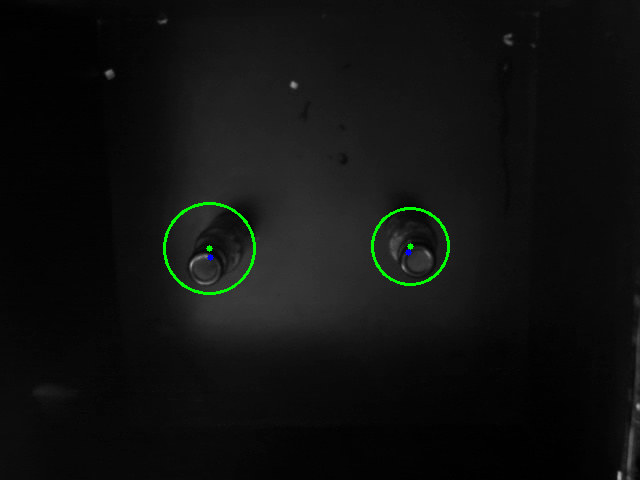

Amostra: Dia4-TR-CCM519-Contexto4
2


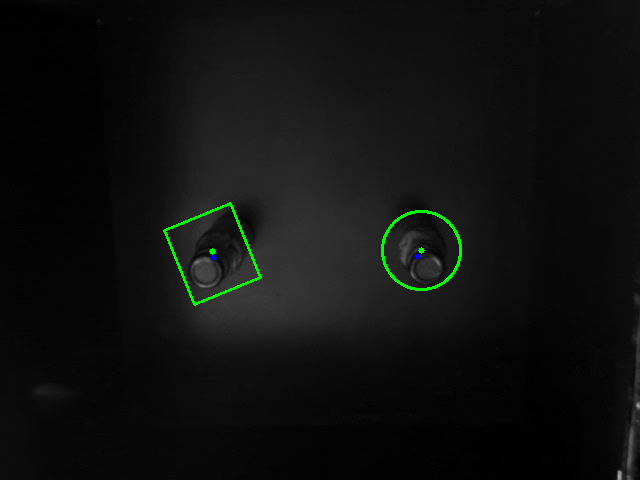

Amostra: Dia4-TR-CCM529-Contexto4
2


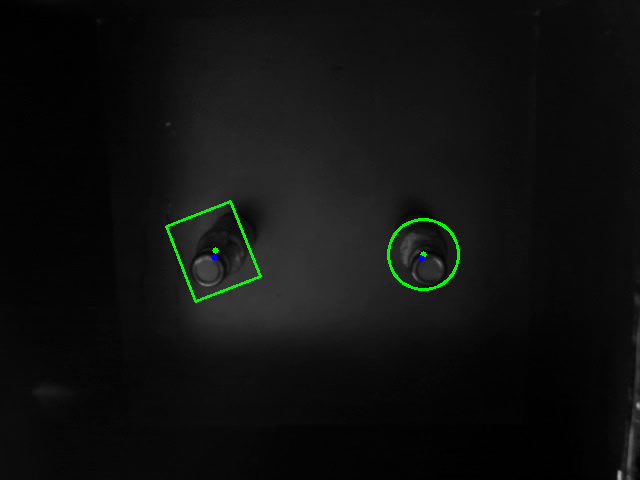

Amostra: Dia4-TR-CCM533-Contexto4
2


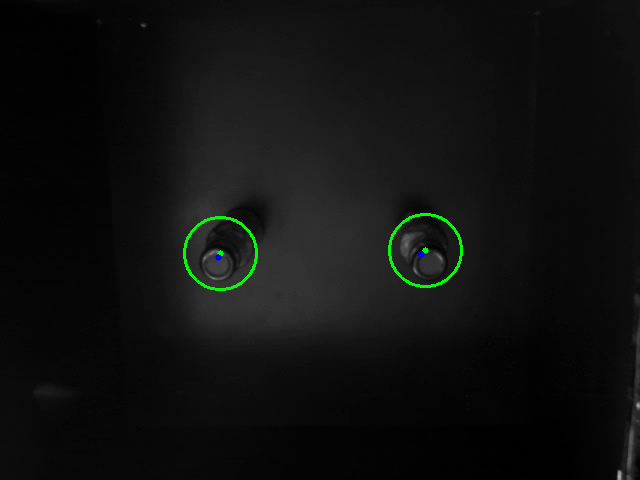

Amostra: Dia4-TR-CCM537-Contexto4
2


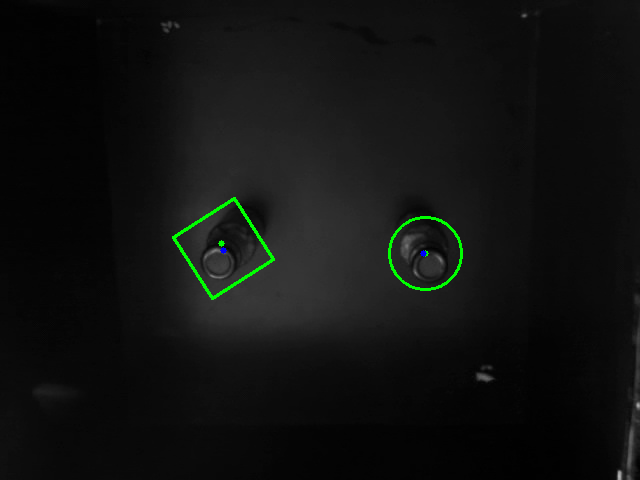

Amostra: Dia4-TR-CCM506-Contexto4
2


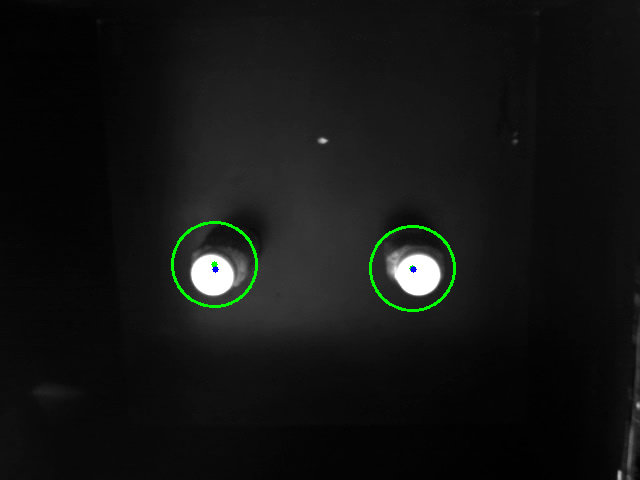

Amostra: Dia4-TR-CCM510-Contexto4
2


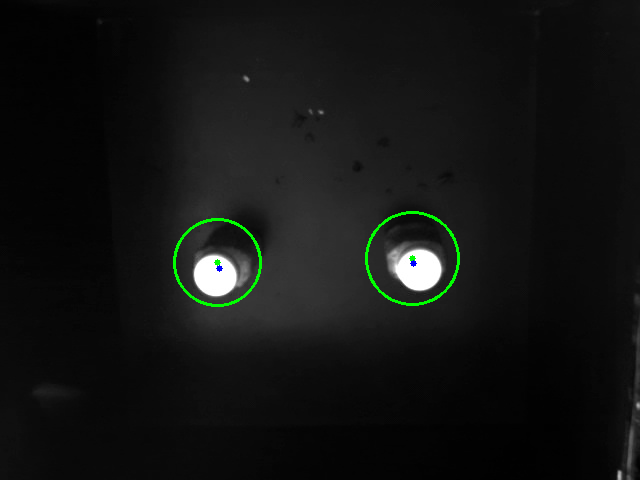

Amostra: Dia4-TT-CCM529-Contexto4
2


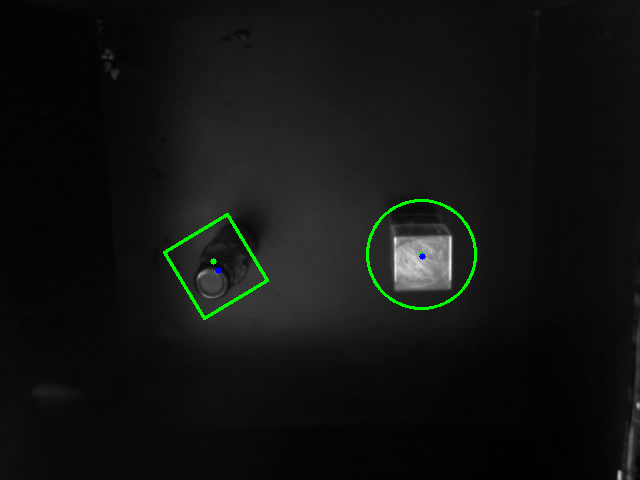

Amostra: Dia4-TT-CCM533-Contexto4
2


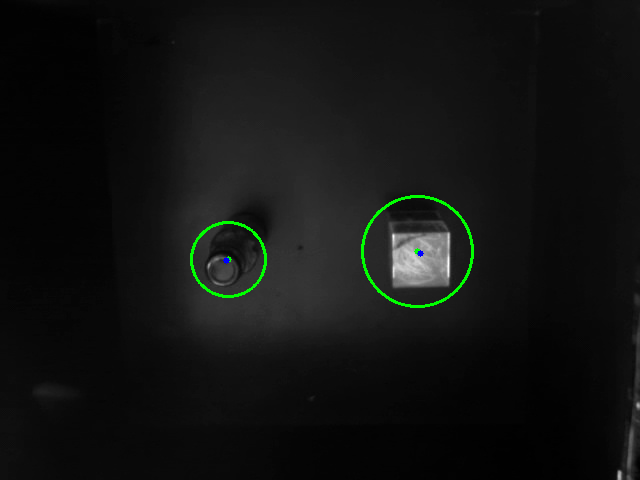

Amostra: Dia5-TT-CCM515-Contexto4
3


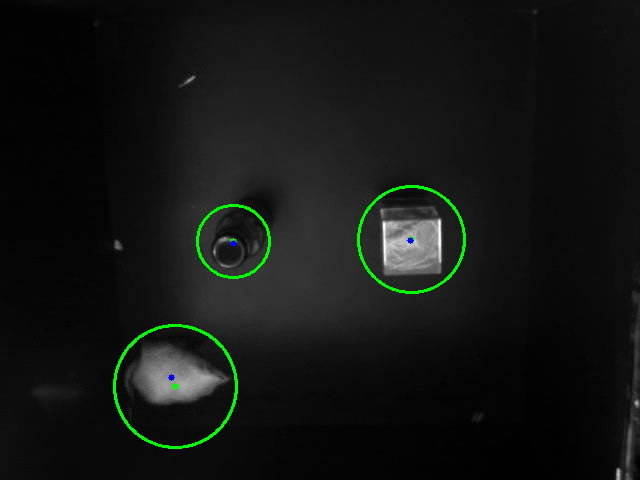

Amostra: Dia5-TT-CCM519-Contexto4
2


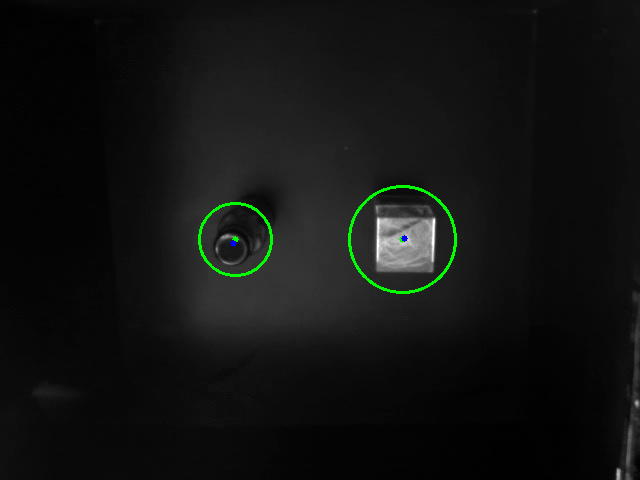

Amostra: Dia5-TT-CCM537-Contexto4
2


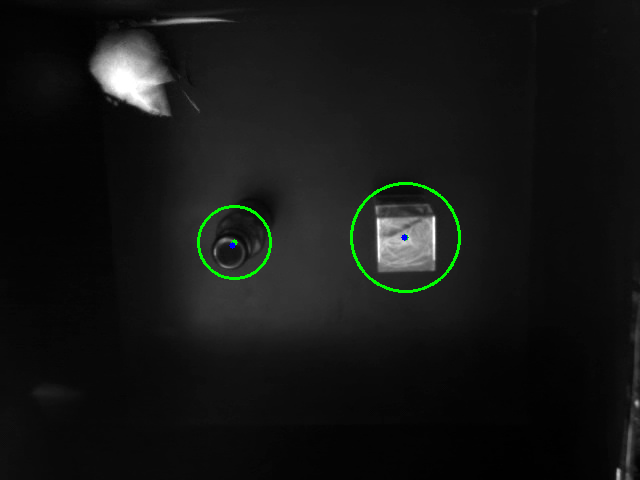

Amostra: Dia5-TT-CCM506-Contexto4
2


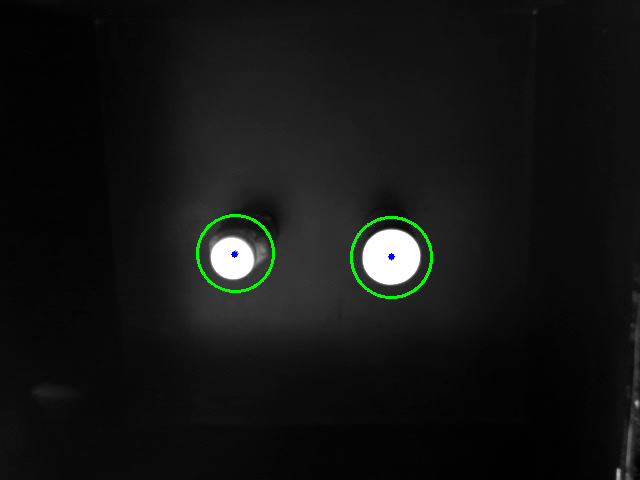

Amostra: Dia5-TT-CCM510-Contexto4
3


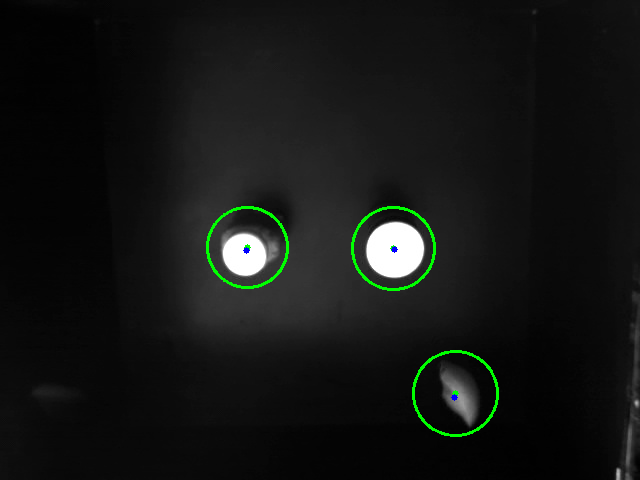

In [ ]:
# Dicionário com os dados de todas as imagens
dados_gerais = {}

# Loop que processa cada arquivo na lista de caminhos de arquivos.
for frame in frames:
  resultados, amostra = process_frame(frame)

  # Imprime o número de objetos encontrados
  print(resultados[1])

  # Exibe a imagem com os contornos encontrados
  cv2_imshow(resultados[0])

  output_path = os.path.join(destino, f"{amostra}_bteste.jpg")

  # Salvar a imagem resultante
  cv2.imwrite(output_path, resultados[0])

  # Dicionário com os dados de uma imagem
  dados_frame = {}

  # Chama a função create_dataset com o dataset gerado
  dados_frame = create_dataset_image(resultados[2])

  # Adicionando os dados em um dicionario maior
  dados_gerais.update(resultados[2])

  output_path_data = os.path.join(destino, f"{amostra}_data.csv")

  # Salva o DataFrame em um arquivo CSV
  dados_frame.to_csv(output_path_data, index=False)

# Chama a função create_dataset_image com o dicionário completo de todas as imagens
dataset_geral = create_dataset_image(dados_gerais)

# Salva o DataFrame em um arquivo CSV
dataset_geral.to_csv(destino + "_dataset_geral.csv", index=False)

# Mineração dos Dados:

In [ ]:
dataset_geral

,attribute,Form,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,distance_of_points
0,Dia4-TR-CCM515-Contexto4_1,circle,2459.5,0.540381,38.000000,381,216,61,64,410,246,408,252,6.324555
1,Dia4-TR-CCM515-Contexto4_2,circle,2998.0,0.324271,45.000000,181,206,69,87,209,248,210,257,9.055385
2,Dia4-TR-CCM519-Contexto4_1,circle,2749.5,0.552896,39.000000,390,220,60,69,421,250,417,256,7.211103
3,Dia4-TR-CCM519-Contexto4_2,Fora do padrão,3517.5,0.277797,47.731117,183,207,68,89,212,251,213,257,58.309519
4,Dia4-TR-CCM529-Contexto4_1,circle,2777.0,0.502996,35.000000,392,225,64,64,423,254,421,258,4.472136
5,Dia4-TR-CCM529-Contexto4_2,Fora do padrão,3230.5,0.283502,47.170006,184,206,68,90,215,250,214,257,59.169249
6,Dia4-TR-CCM533-Contexto4_1,circle,2593.5,0.647645,36.000000,392,224,64,59,425,250,421,254,5.656854
7,Dia4-TR-CCM533-Contexto4_2,circle,2616.5,0.459018,36.000000,193,218,62,71,220,253,218,257,4.472136
8,Dia4-TR-CCM537-Contexto4_1,circle,2792.0,0.343925,36.000000,392,221,64,63,425,253,423,253,2.000000
9,Dia4-TR-CCM537-Contexto4_2,Fora do padrão,3149.0,0.235771,44.477623,192,202,68,86,221,243,223,250,57.140179


In [ ]:
dataset_geral.describe()

,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,distance_of_points
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,3864.350000,0.521458,43.298980,284.566667,222.100000,71.866667,77.433333,317.700000,259.866667,317.333333,262.933333,11.139494
std,1420.577755,0.178177,7.080779,99.527395,35.124753,11.589928,9.964362,100.086566,36.114505,99.889019,34.935343,18.961259
min,2103.000000,0.235771,35.000000,116.000000,191.000000,56.000000,59.000000,175.000000,237.000000,171.000000,237.000000,1.000000
25%,2755.875000,0.348053,37.250000,192.250000,207.000000,64.000000,69.000000,220.250000,246.250000,220.000000,250.000000,2.059017
50%,3374.000000,0.516927,42.000000,282.500000,217.000000,68.500000,77.000000,319.000000,251.000000,318.500000,256.000000,4.297621
75%,4528.250000,0.680957,46.877504,379.250000,221.750000,77.000000,87.000000,412.000000,257.750000,413.000000,259.500000,6.324555
max,6661.000000,0.820203,61.000000,431.000000,355.000000,120.000000,91.000000,455.000000,393.000000,454.000000,397.000000,59.169249


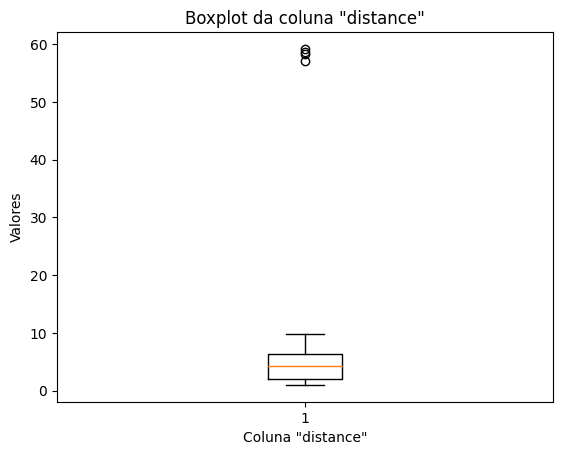

In [ ]:
# Acesse a coluna "distance" do DataFrame
coluna_distance = dataset_geral['distance_of_points']

# Crie um boxplot da coluna "distance"
plt.boxplot(coluna_distance)

# Adicione rótulos e título ao gráfico
plt.xlabel('Coluna "distance"')
plt.ylabel('Valores')
plt.title('Boxplot da coluna "distance"')

# Exiba o gráfico
plt.show()

In [ ]:
qtd_amostras = coluna_distance.count()

# Defina o limiar
limiar = 10

# Area de interesse:
ideais = 3

# Conte o número de amostras que são superiores ao limiar
contador = np.sum(coluna_distance > limiar)

# Conte o número de amostras que são superiores ao limiar
desejo = np.sum(coluna_distance < ideais)

# Imprima o resultado
print(f"temos ({qtd_amostras}) amostras no total.")

# Imprima o resultado
print(f"Número de amostras acima ({limiar}) unidades de distancia: {contador}")

# Imprima o resultado
print(f"Número de amostras abixo de ({ideais}) unidades de distancia: {desejo}")

temos (30) amostras no total.
Número de amostras acima (10) unidades de distancia: 4
Número de amostras abixo de (3) unidades de distancia: 11
